In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
'''
Pandas는 데이터 파일을 읽어 데이터프레임을 만들 수 있다
CSV(Comman Separated Value)파일 포맷은 데이터 값이 쉽표(comma)로 구분되는 텍스트 파일이다.
CSV 파일로부터 데이터를 읽어 데이터프레임을 만들 때는 pandas.read_csv() 명령을 사용한다.
https://datascienceschool.net/view-notebook/c5ccddd6716042ee8be3e5436081778b/

Pandas는 numpy행렬과 같이 쉼표를 사용한 (행 인덱스, 열 인덱스) 형식의 2차원 인덱싱을 지원하기 위해 다음과 같은 특별한 인덱서(indexer)를 제공한다.

loc : 라벨값 기반의 2차원 인덱싱
iloc : 순서를 나타내는 정수 기반의 2차원 인덱싱
at: 라벨값 기반의 2차원 인덱싱 (한개의 스칼라 값만 찾는다)
iat : 순서를 나타내는 정수 기반의 2차원 인덱싱 (한개의 스칼라 값만 찾는다)
https://datascienceschool.net/view-notebook/704731b41f794b8ea00768f5b0904512/
'''
import os
import time
import copy

from PIL import Image
'''
Pillow는 파이썬 이미징 라이브러리로서 여러 이미지 파일 포맷을 지원하고, 
이미지 내부 데이타를 엑세스할 수 있게 하며, 다양한 이미지 처리 기능을 제공하고 있다. 
Image.open() 로부터 리턴된 이미지 객체의 size 속성은 이미지의 크기를 리턴한다.
http://pythonstudy.xyz/python/article/406-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%B2%98%EB%A6%AC
'''

DATASET_SIZE = 1000 #2500
BATCH_SIZE = 15  #15
W = H = 256

train_path = 'C:/data/train/'
test_path = 'C:/data/test/'
train_csv_path = 'C:/data/train.csv'


LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  ,
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

LABELS = []

for label in LABEL_MAP.values():
    LABELS.append(label)

print(LABELS)

['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center', 'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus', 'Peroxisomes', 'Endosomes', 'Lysosomes', 'Intermediate filaments', 'Actin filaments', 'Focal adhesion sites', 'Microtubules', 'Microtubule ends', 'Cytokinetic bridge', 'Mitotic spindle', 'Microtubule organizing center', 'Centrosome', 'Lipid droplets', 'Plasma membrane', 'Cell junctions', 'Mitochondria', 'Aggresome', 'Cytosol', 'Cytoplasmic bodies', 'Rods & rings']


we have 31072 different samples
And there are 582 different combinations of labels in our dataset


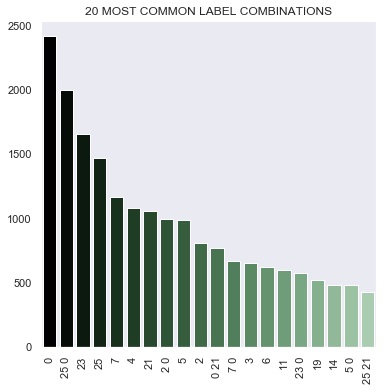

In [2]:
df = pd.read_csv(train_csv_path)

TRAINING_SAMPLES = df.shape[0]

print("we have " + str(TRAINING_SAMPLES) + " different samples")
print("And there are "+  str(len(df.Target.unique())) + " different combinations of labels in our dataset")

import seaborn as sns
sns.set(style="dark")

n = 20

values = df['Target'].value_counts()[:n].keys().tolist()
counts = df['Target'].value_counts()[:n].tolist()

plt.figure(figsize=(6,6))
pal = sns.cubehelix_palette(n, start=2, rot=0, dark=0, light=.75, reverse=True)
g = sns.barplot(y=counts, x=values, palette=pal)
g.set_title(str(n)+" MOST COMMON LABEL COMBINATIONS")
g.set_xticklabels(g.get_xticklabels(),rotation=90);

In [3]:
from PIL import Image

def load_image(basepath, image_id):
    images = np.zeros(shape=(256,256,4))
    r = Image.open(basepath+image_id+"_red.png").resize((256,256))
    g = Image.open(basepath+image_id+"_green.png").resize((256,256))
    b = Image.open(basepath+image_id+"_blue.png").resize((256,256))
    y = Image.open(basepath+image_id+"_yellow.png").resize((256,256))

    images[:,:,0] = np.asarray(r)
    images[:,:,1] = np.asarray(g)
    images[:,:,2] = np.asarray(b)
    images[:,:,3] = np.asarray(y)
    
    return images

In [4]:
targets = df['Target'].value_counts().keys()
counts = df['Target'].value_counts().values

how_many = counts/TRAINING_SAMPLES*DATASET_SIZE

# at least one example of each possible combination of labels..
how_many = how_many.astype('int')+1

In [5]:
import torch
import numpy as np
import pandas as pd
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform
from sklearn.preprocessing import MultiLabelBinarizer
classes = np.arange(0,28)
mlb = MultiLabelBinarizer(classes)
mlb.fit(classes)

#경고를 필터링
import warnings
warnings.filterwarnings("ignore")


class HumanProteinDataset(Dataset):

    def __init__(self, csv_file, transform=None, test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            test (Boolean): the csv no contains labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.test = test
        self.complete_df = pd.read_csv(csv_file)

        if not test:
            self.path = train_path
            self.loadData()

        else:
            self.path = test_path
            self.df = self.complete_df

        self.transform = transform
        
        
    def CreateDummyVariables(self):
        self.complete_df['Targets'] = self.complete_df['Target'].map(lambda x: list(map(int, x.strip().split())))
    
    def loadData(self):
        self.CreateDummyVariables()
        self.df = pd.DataFrame(columns=['Id','Target'])
        for i, target in enumerate(targets):
            fdf = self.complete_df[self.complete_df['Target'] == target]
            sample = fdf.sample(n=how_many[i], replace=False)
            self.df = self.df.append(sample)
        self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, idx):

        #id  - 모든 샘플은 파란색, 녹색, 빨간색 및 노란색의 네 가지 파일로 구성된다
        #df.iloc[행 인덱스, 열 인덱스], 하나만 있을 때는 행을 선택

        #Target - training data에서 각 샘플에 할당된 label을 나타낸다.

        #>>> for i, stock in enumerate(['Naver', 'KAKAO', 'SK']): print(i, stock) ;
        #0 Naver ; 1 KAKAO ; 2 SK

        image = load_image(self.path, self.df['Id'].iloc[idx])
        
        sample = {'image': image}

        if not self.test:
            target = np.array(self.complete_df['Targets'].iloc[idx])
            target = mlb.transform([target])
            sample['target'] = target
        
        else:
            sample['Id'] = self.df['Id'].iloc[idx]

        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return self.df.shape[0]
    
    def shape(self):
        return self.df.shape


# class Normalize(object):
#     """normalize the color range to [0,1] of each channel."""

#     def __call__(self, sample):
#         images = sample['Images']

#         images_copy = np.copy(images)

#         # scale color range from [0, 255] to [0, 1]
#         images_copy = images_copy / 255.0

#         return {'Id': sample['Id'], 'Targets': sample['Targets'], 'Images': images_copy}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image = sample['image']/255.0
        
        totensor = transforms.ToTensor()
        
        ret = {'image': totensor(image)}
        
        if "target" in sample.keys():
            target = sample['target'][0]
            ret['target'] = target
        else:
            ret['Id'] = sample['Id']
                  
        return ret


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # 조건에 맞지 않으면 error
        #isinstance(object, class)는 첫 번째 인수로 인스턴스, 두 번째 인수로 클래스 이름을 받는다.
        # 입력으로 받은 인스턴스가 그 클래스의 인스턴스인지를 판단하여 참이면 True, 거짓이면 False를 리턴한다.
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['Images']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'Id': sample['Id'], 'Targets': sample['Targets'], 'Images': img}


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


def Show(sample):
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 25), sharey=True)

    title = ''
    labels =sample['target']

    for i, label in enumerate(LABELS):
        if labels[i] == 1:
            if title == '':
                title += label
            else:
                title += " & " + label

    ax1.imshow(sample['image'][0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(sample['image'][1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(sample['image'][2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(sample['image'][3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)

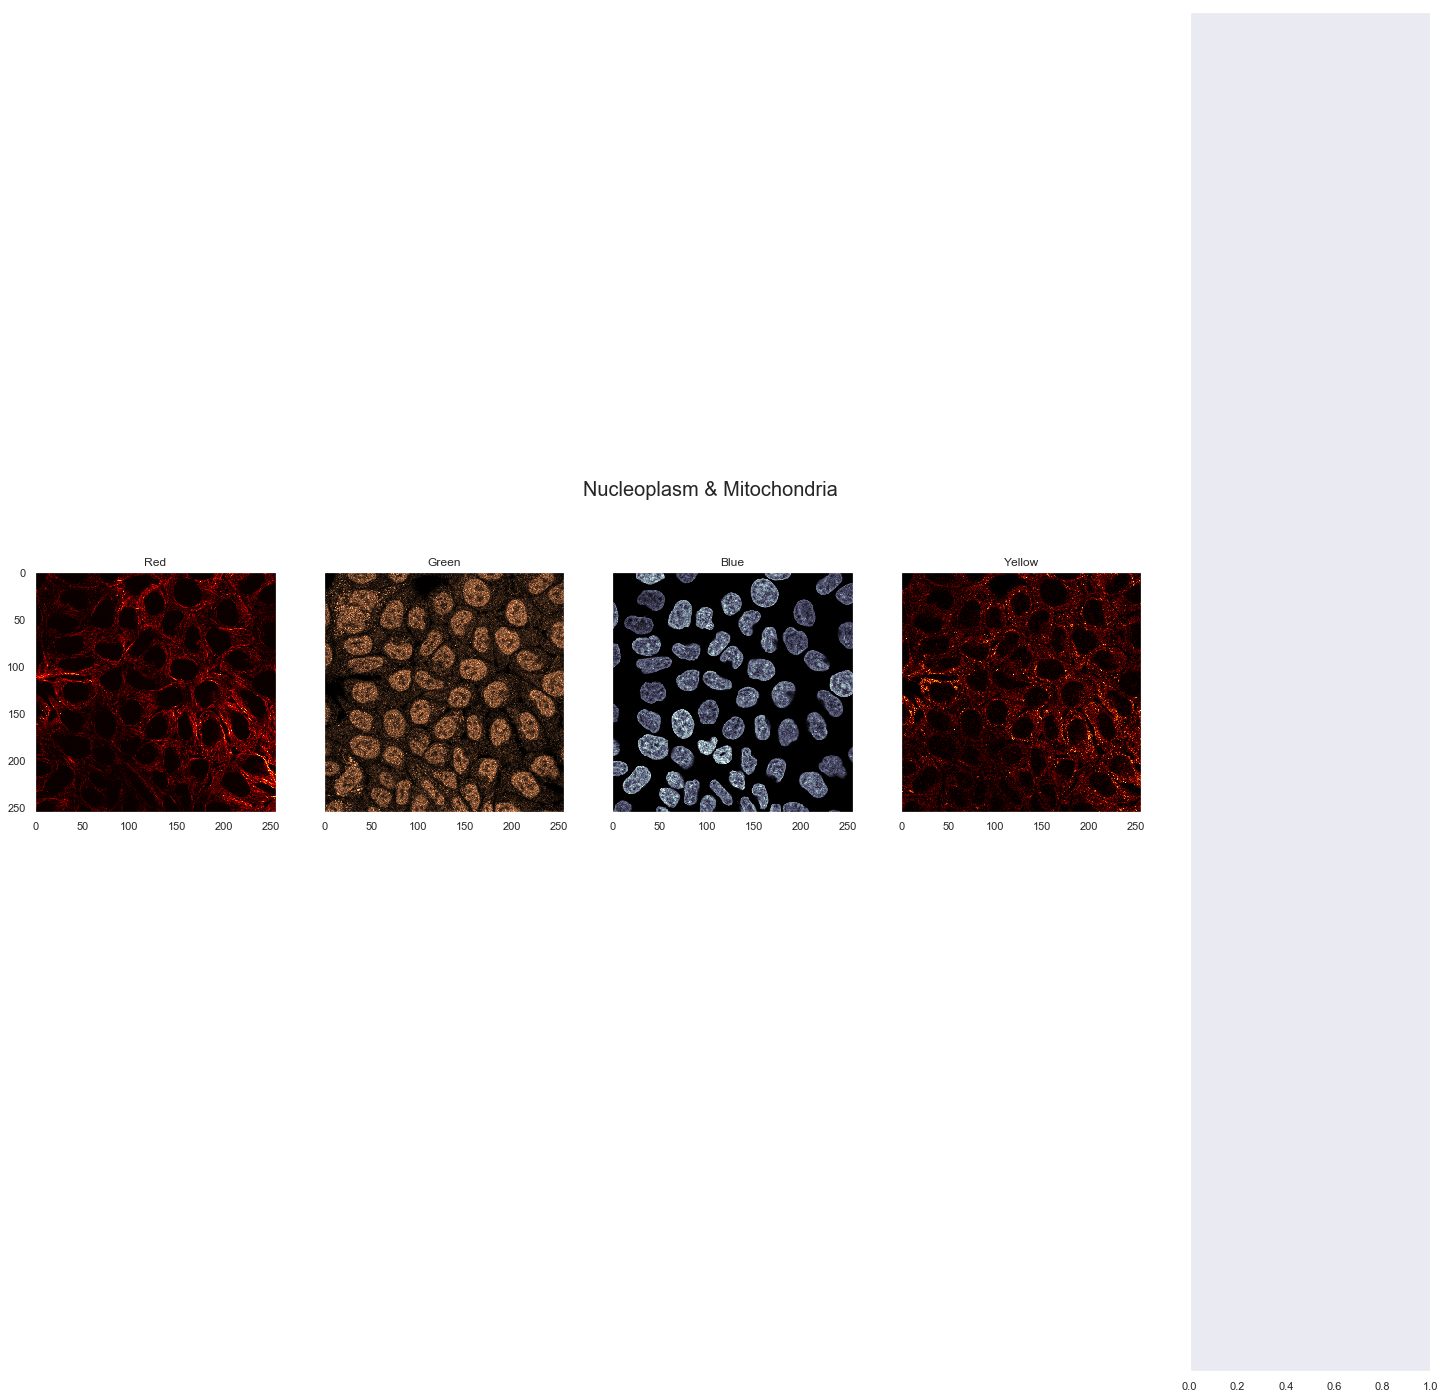

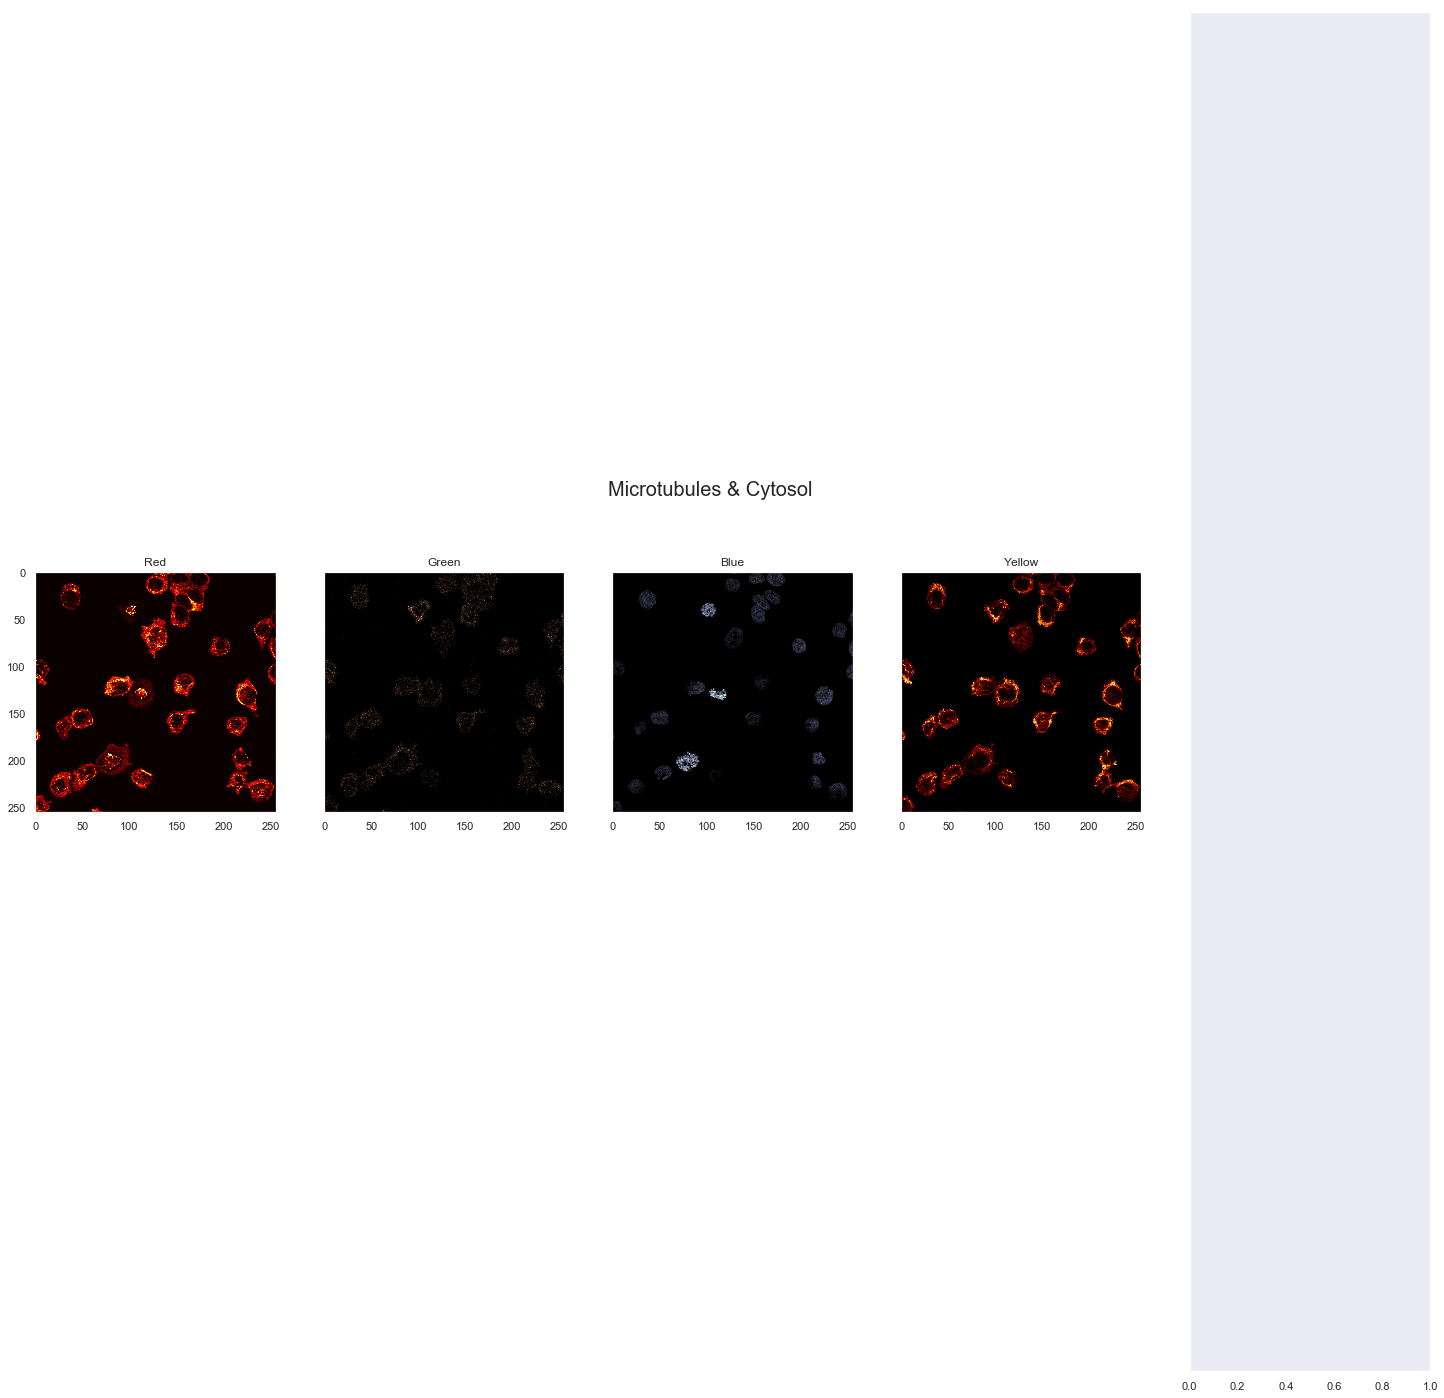

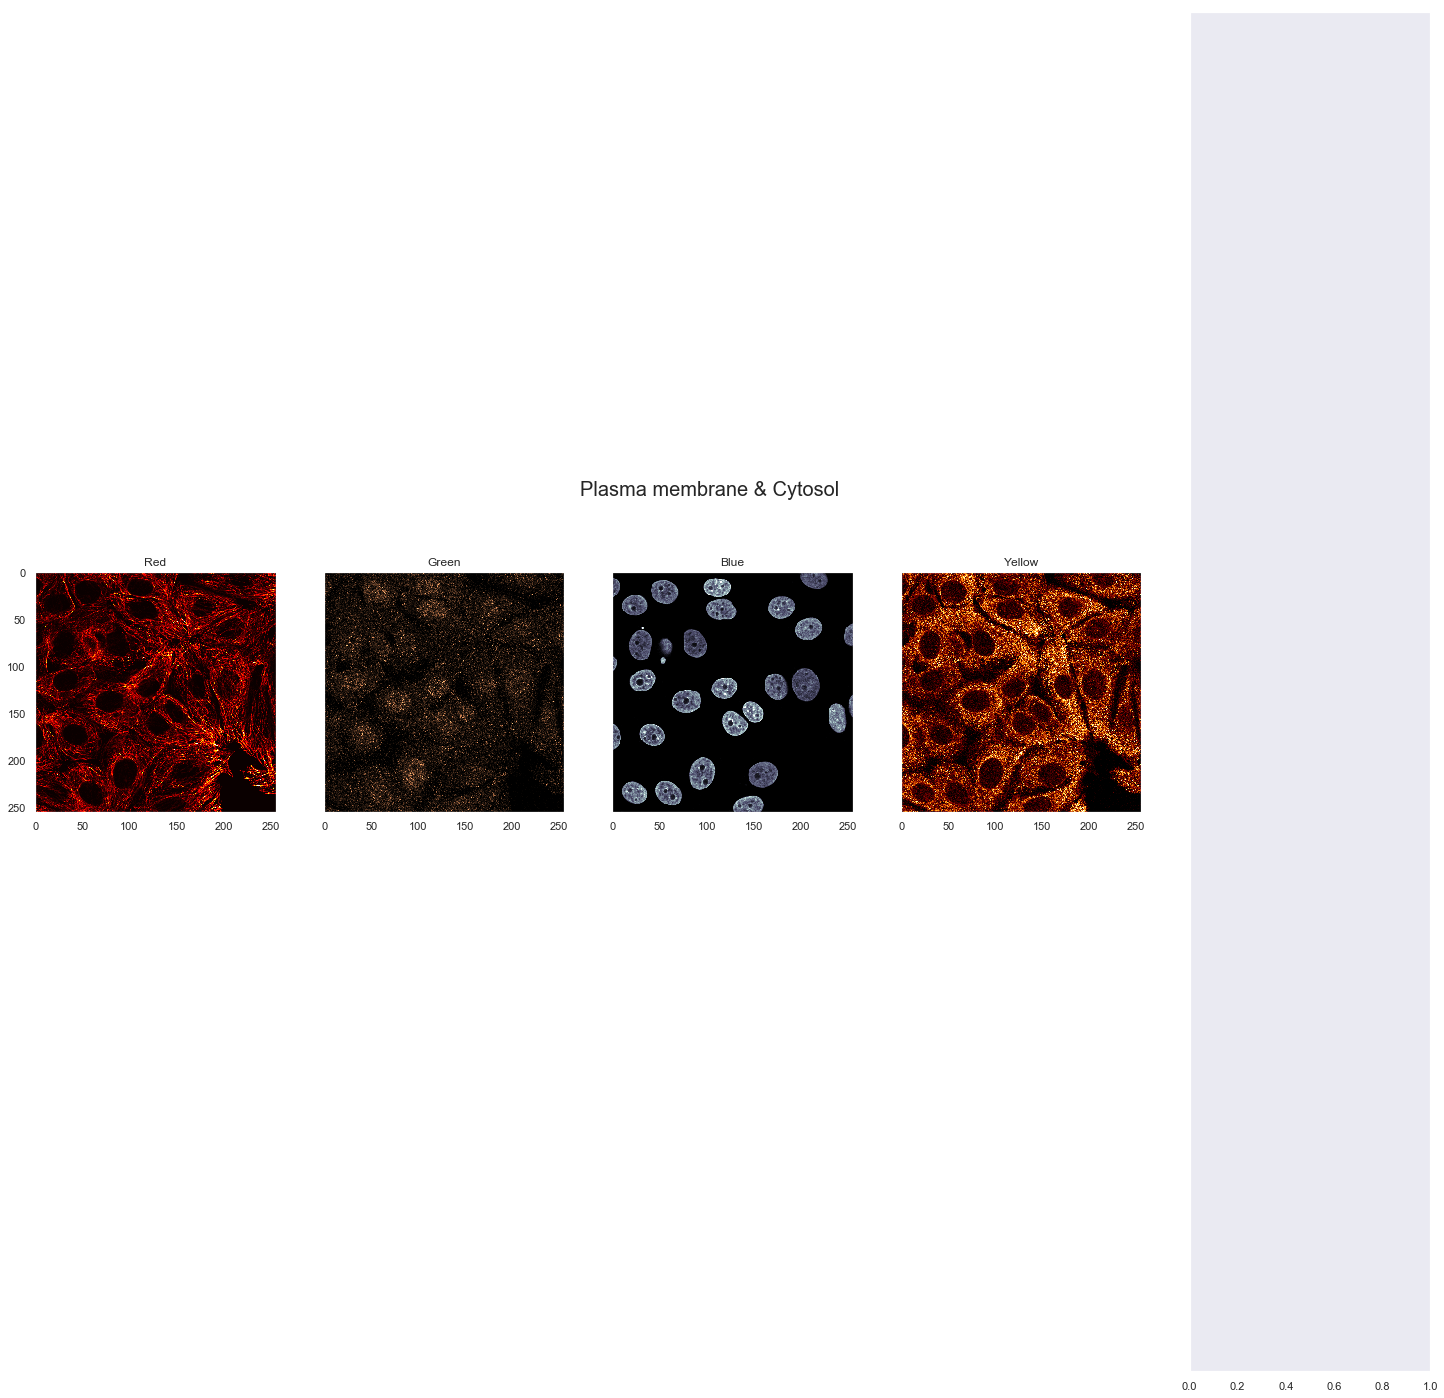

In [6]:
import random

dataset = HumanProteinDataset(train_csv_path, transform=ToTensor())

# dataset.df = dataset.df.sample(frac=0.005, replace=True)

# dataloader = DataLoader(dataset, batch_size=500,
#                         shuffle=True, num_workers=4)

idxs = random.sample(range(1, dataset.df.shape[0]), 3)

for idx in idxs:
    Show(dataset[idx])

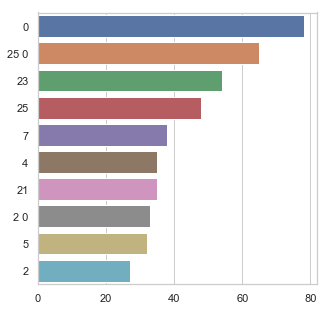

In [7]:
#////////////////////////////@######################
#Different sample types
import seaborn as sns
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
# 10 most common
values = dataset.df['Target'].value_counts()[:10].keys().tolist()
counts = dataset.df['Target'].value_counts()[:10].tolist()

plt.figure(figsize=(5,5))
sns.barplot(y=values, x=counts)

# training a model with CNN

## split training dataset into training+validation

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import math

def prepare_loaders():
    dataset.loadData()
    num_train = len(dataset)
    indices = list(range(num_train))
    val_size = int(0.45 * num_train) 

    # Random, non-contiguous split
    validation_idx = np.random.choice(indices, size=val_size, replace=False)
    train_idx = list(set(indices) - set(validation_idx))

    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(validation_idx)

    dataset_sizes = {}

    dataset_sizes['train'] = len(train_idx)
    dataset_sizes['val'] = len(validation_idx)
    
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE,num_workers=0, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0,sampler=validation_sampler)

    dataloaders = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = validation_loader
    
    return (dataloaders, dataset_sizes)

In [9]:
dataloaders, dataset_sizes = prepare_loaders()

dataset.df.head()

,Id,Target,Targets
0,4f373c66-bb9f-11e8-b2b9-ac1f6b6435d0,19 25 4,"[19, 25, 4]"
1,1434399e-bbad-11e8-b2ba-ac1f6b6435d0,14 2,"[14, 2]"
2,b29cffca-bb9a-11e8-b2b9-ac1f6b6435d0,25 5 0,"[25, 5, 0]"
3,4f47c4b8-bbb9-11e8-b2ba-ac1f6b6435d0,25 2,"[25, 2]"
4,a302234c-bbb8-11e8-b2ba-ac1f6b6435d0,7,[7]


In [11]:
# Wout = 1 + (Win - Kernel_size + 2Padding)/Stride

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(      #input: 4xWxH  #input 이 512x512인가? 
            nn.Conv2d(4,8,5,1,2),        # input_channels, output_channels, kernel_size, stride, padding   
            nn.BatchNorm2d(8),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #output: 8xW/2xH/2
        )
        self.conv2 = nn.Sequential(      #input: 4xWxH
            nn.Conv2d(8,16,5,1,2),        # input_channels, output_channels, kernel_size, stride, padding   
            nn.BatchNorm2d(16),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #output: 16xW/4xH/4
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear( int(16 * W/4 * H/4), 900)   # fully connected layer, output 28 classes
#         self.out1 = nn.Linear( 67600, 900)
        self.out2 = nn.Linear( 900, 28)   # fully connected layer, output 28 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        return output, x    # return x for visualization

def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

Train(cnn, epochs=5,  criterion=nn.BCEWithLogitsLoss(), optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))

In [12]:
# create a new subdataset for training
dataloaders, dataset_sizes = prepare_loaders()


losses = {}
accuracys = {}

losses['train'] = []
losses['val'] = []
accuracys['train'] = []
accuracys['val'] = []




In [13]:
def Train(model, epochs=10, criterion=nn.BCEWithLogitsLoss(reduction='sum'), optimizer= None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=0.04, betas=(0.9, 0.99))
    
    device = torch.device("cpu")
    print("training with device: " + str(device))
    
    model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0    
            running_corrects = 0.0
    
            for i, data in enumerate(dataloaders[phase], 0):            
                # get the inputs
                inputs, labels = data['image'], data['target']

                inputs, labels = inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)[0]
                    preds = outputs > 0
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase 
                    # training 단계일 때면 backward, optimize 실행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                 # statistics
                running_loss += loss.item() * inputs.size(0)
                labels = labels.data.byte()
                running_corrects += torch.sum((labels == preds).all(1))
                                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            losses[phase].append(epoch_loss)
            accuracys[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def run_model(model,batch):
    device = torch.device("cpu")
    model.to(device)
    inputs = batch
    inputs = inputs.to(device,dtype=torch.float)
    out = model(inputs)
    out = out[0].cpu()
    return out

In [14]:
# model creation and initialization
cnn = CNN()
cnn.apply(init_weights)

CNN(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [16]:
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), 
            optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))

training with device: cpu
Epoch 1/10
----------
train Loss: 54.8094 Acc: 0.5417
val Loss: 244.5478 Acc: 0.0154
Epoch 2/10
----------
train Loss: 17.2756 Acc: 0.7475
val Loss: 243.9865 Acc: 0.0417
Epoch 3/10
----------
train Loss: 11.7324 Acc: 0.8220
val Loss: 280.0716 Acc: 0.0586
Epoch 4/10
----------
train Loss: 9.6248 Acc: 0.8447
val Loss: 339.6021 Acc: 0.0309
Epoch 5/10
----------
train Loss: 13.3162 Acc: 0.8232
val Loss: 306.5727 Acc: 0.0324
Epoch 6/10
----------
train Loss: 13.7202 Acc: 0.8056
val Loss: 304.3650 Acc: 0.0293
Epoch 7/10
----------
train Loss: 6.8820 Acc: 0.8939
val Loss: 324.7746 Acc: 0.0324
Epoch 8/10
----------
train Loss: 6.6892 Acc: 0.8927
val Loss: 287.1917 Acc: 0.0556
Epoch 9/10
----------
train Loss: 5.6113 Acc: 0.8990
val Loss: 359.8489 Acc: 0.0247
Epoch 10/10
----------
train Loss: 4.9466 Acc: 0.9242
val Loss: 327.3827 Acc: 0.0278
Training complete in 73m 6s
Best val Acc: 0.058642


In [22]:
# training
# torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), 
            optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))
dataloaders, dataset_sizes = prepare_loaders()
# torch.cuda.empty_cache()
cnn = Train(cnn, epochs=10,  criterion=nn.BCEWithLogitsLoss(reduction='sum'), 
            optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99)))

training with device: cpu
Epoch 1/10
----------
train Loss: 75.8080 Acc: 0.0707
val Loss: 85.8433 Acc: 0.0216
Epoch 2/10
----------
train Loss: 33.4519 Acc: 0.4432
val Loss: 110.9297 Acc: 0.0293
Epoch 3/10
----------
train Loss: 12.5779 Acc: 0.8384
val Loss: 173.2305 Acc: 0.0386
Epoch 4/10
----------
train Loss: 3.9728 Acc: 0.9558
val Loss: 184.8873 Acc: 0.0386
Epoch 5/10
----------
train Loss: 2.6175 Acc: 0.9722
val Loss: 242.1612 Acc: 0.0293
Epoch 6/10
----------
train Loss: 3.7576 Acc: 0.9508
val Loss: 237.2357 Acc: 0.0340
Epoch 7/10
----------
train Loss: 7.9464 Acc: 0.9015
val Loss: 219.6406 Acc: 0.0324
Epoch 8/10
----------
train Loss: 1.8039 Acc: 0.9760
val Loss: 257.7622 Acc: 0.0370
Epoch 9/10
----------
train Loss: 1.4974 Acc: 0.9798
val Loss: 275.8158 Acc: 0.0386
Epoch 10/10
----------
train Loss: 1.4370 Acc: 0.9823
val Loss: 249.1289 Acc: 0.0340
Training complete in 150m 59s
Best val Acc: 0.038580
training with device: cpu
Epoch 1/10
----------
train Loss: 132.1886 Acc: 0.01

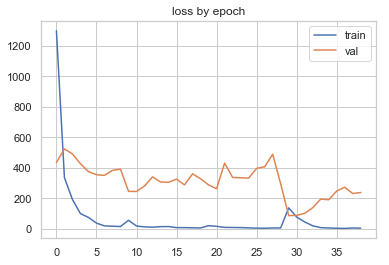

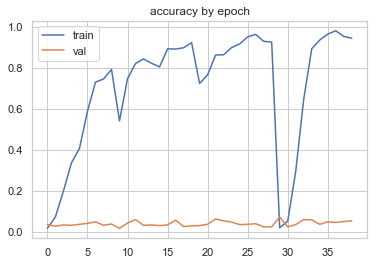

In [18]:
plt.plot(np.arange(len(losses['train'])), losses['train'],label="train")
plt.plot(np.arange(len(losses['val'])), losses['val'], label="val")
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(accuracys['train'])), accuracys['train'], label="train")
plt.plot(np.arange(len(accuracys['val'])), accuracys['val'], label="val")
plt.title("accuracy by epoch")
plt.legend()
plt.show()

# Submit

In [19]:
submit = pd.read_csv('C:/data/sample_submission.csv')

dataset_test = HumanProteinDataset(csv_file='C:/data/sample_submission.csv', transform=transforms.Compose([
    ToTensor()
]), test=True)

dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

In [20]:
a = torch.rand(5,4,W,H)
outs = run_model(cnn, a)
print(outs)

tensor([[-0.1393, -0.5543, -0.4054, -0.4756, -0.4668, -0.4587, -0.3649, -0.4043,
         -1.6862, -1.4842, -1.3675, -0.6123, -0.8415, -0.8946, -0.4307, -2.5726,
         -0.9811, -1.0315, -0.6076, -0.5727, -0.8657, -0.4465, -0.5848, -0.5364,
         -1.0809, -0.2224, -0.9532, -1.7113],
        [-0.1339, -0.5468, -0.3950, -0.4834, -0.4839, -0.4444, -0.3663, -0.3834,
         -1.6757, -1.4773, -1.3649, -0.6091, -0.8440, -0.8936, -0.4192, -2.5630,
         -0.9843, -1.0193, -0.6012, -0.5551, -0.8709, -0.4350, -0.5893, -0.5472,
         -1.0833, -0.2353, -0.9506, -1.6983],
        [-0.1372, -0.5855, -0.4116, -0.4992, -0.5076, -0.4596, -0.3575, -0.3818,
         -1.6817, -1.4781, -1.3646, -0.6182, -0.8195, -0.9040, -0.4132, -2.5691,
         -0.9823, -1.0312, -0.6074, -0.5494, -0.8692, -0.4308, -0.5934, -0.5387,
         -1.0789, -0.2177, -0.9300, -1.7016],
        [-0.1459, -0.5686, -0.4203, -0.5059, -0.4920, -0.4582, -0.3692, -0.3987,
         -1.6932, -1.4925, -1.3782, -0.6145, -0.8302

In [25]:
ids = []
predictions = []

# cnn = cnn.cuda()

for sample_batched in dataloader_test:
        out = run_model(cnn,sample_batched['image'])
        
        preds = []
        out = out.detach().numpy()
        for sample in out:
            p = ""
            for i,label in enumerate(sample):
                if label > 0:
                    p += " " + str(i)
#                     print(p)
            if p == "":
                p = "0"
            else:
                p = p[1:]
            preds.append(p)

        ids += list(sample_batched['Id'])
        predictions += preds

In [27]:
print(predictions)

['0', '2', '0', '0', '0', '0', '0', '0', '0', '25', '0', '25', '0 25', '25', '0', '0', '0 25', '25', '0', '0', '0', '0 3 21 25', '0', '0', '0', '25', '0 2 21', '25', '25', '0', '0', '25', '0 2', '0', '0', '0', '0', '0', '0 25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '0', '0 25', '25', '25', '0', '0', '0', '0 25', '0', '0', '0', '0', '0', '0', '0', '0', '25', '0 23 25', '0', '0', '0', '0 25', '1 11', '2', '0', '0', '0', '0', '18 25', '25', '2', '0', '0', '0 25', '0', '0', '0 25', '21', '0', '2 25', '7', '0', '0 25', '0 25', '0', '0', '0 2', '23', '0 7 23 25', '0', '0', '0', '0 25', '0', '2', '0', '2', '0 25', '23', '0 25', '0', '0', '0', '0 11 21 25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '25', '25', '2', '25', '0 23', '0 25', '0', '0', '25', '0', '0', '21', '0 25', '25', '0 25', '0', '0 25', '0 25', '0 25', '0', '0', '0', '25', '0', '0 2', '0', '0', '0', '0 25', '0', '

In [28]:
df = pd.DataFrame({'Id':ids,'Predicted':predictions})
df.to_csv('C:/data/protein_classification.csv', header=True, index=False)

print(df)

                                         Id  Predicted
0      00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
1      0000a892-bacf-11e8-b2b8-ac1f6b6435d0          2
2      0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
3      0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
4      000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
5      00109f6a-bac8-11e8-b2b7-ac1f6b6435d0          0
6      001765de-bacd-11e8-b2b8-ac1f6b6435d0          0
7      0018641a-bac9-11e8-b2b8-ac1f6b6435d0          0
8      00200f22-bad7-11e8-b2b9-ac1f6b6435d0          0
9      0026f154-bac6-11e8-b2b7-ac1f6b6435d0         25
10     002729d2-bace-11e8-b2b8-ac1f6b6435d0          0
11     002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0         25
12     003170fa-bacd-11e8-b2b8-ac1f6b6435d0       0 25
13     0031820a-baca-11e8-b2b8-ac1f6b6435d0         25
14     00407c16-bad3-11e8-b2b8-ac1f6b6435d0          0
15     005ce2ea-bacc-11e8-b2b8-ac1f6b6435d0          0
16     00631ec8-bad9-11e8-b2b9-ac1f6b6435d0       0 25
17     006

In [ ]:
# train_labels = pd.read_csv("C:/data/train.csv")
# # train_labels.head()

# label_names = {
#     0:  "Nucleoplasmn",  
#     1:  "Nuclear membrane",   
#     2:  "Nucleoli",   
#     3:  "Nucleoli fibrillar center",   
#     4:  "Nuclear speckles",
#     5:  "Nuclear bodies",   
#     6:  "Endoplasmic reticulum",   
#     7:  "Golgi apparatus",   
#     8:  "Peroxisomes",   
#     9:  "Endosomes",   
#     10:  "Lysosomes", 
#     11:  "Intermediate filaments",   
#     12:  "Actin filaments",   
#     13:  "Focal adhesion sites",   
#     14:  "Microtubules",   
#     15:  "Microtubule ends",   
#     16:  "Cytokinetic bridge",   
#     17:  "Mitotic spindle",   
#     18:  "Microtubule organizing center",   
#     19:  "Centrosome",   
#     20:  "Lipid droplets",   
#     21:  "Plasma membrane",   
#     22:  "Cell junctions",   
#     23:  "Mitochondria",   
#     24:  "Aggresome",   
#     25:  "Cytosol",   
#     26:  "Cytoplasmic bodies",   
#     27:  "Rods & rings"
# }

# reverse_train_labels = dict((v,k) for k,v in label_names.items())

# def fill_targets(row):
#     row.Target = np.array(row.Target.split(" ")).astype(np.int)
#     for num in row.Target:
#         name = label_names[int(num)]
#         row.loc[name] = 1
#     return row

# for key in label_names.keys():
#     train_labels[label_names[key]] = 0

# train_labels = train_labels.apply(fill_targets, axis=1)

# train_labels.head()